In [4]:

from os import listdir
from os.path import isfile, join
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable
from robotpy_apriltag import AprilTagDetector

In [109]:
path = ".\\data\\apriltags"
images = [cv2.imread(join(path, f), cv2.IMREAD_GRAYSCALE) for f in listdir(path) if isfile(join(path, f))]
len(images)

23

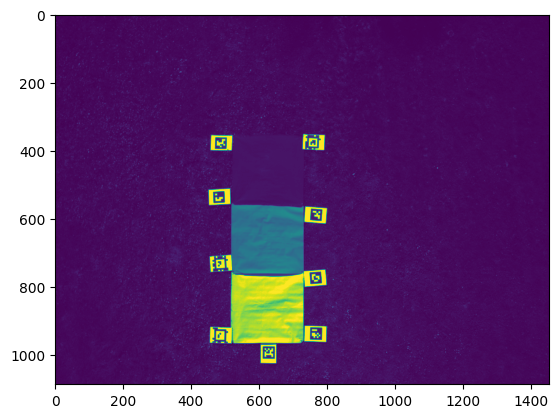

In [110]:
plt.imshow(images[0])

In [31]:
families = [
    "tag16h5",
    "tag25h9",
    "tagStandard41h12"
]
detectors: List[AprilTagDetector] = []
for family in families:
    d = AprilTagDetector()
    d.addFamily(family)
    config = AprilTagDetector.Config()
    config.quadDecimate = 1.0
    config.numThreads = 4
    config.refineEdges = 1.0
    d.setConfig(config)
    detectors.append(d)

In [130]:
def verify_detection(tag) -> bool:
    valid_ids = [0, 4, 9]
    return tag.getId() in valid_ids


def filter_detections(tags):
    return [tag for tag in tags if verify_detection(tag)]

In [131]:
def detect_tags(img, filter=True):
    TAG_AMOUNT = 3  # Assuming there is the same number of tags for each family
    if filter:
        return [len(filter_detections(detector.detect(img))) - TAG_AMOUNT for detector in detectors]
    else:
        return [len(detector.detect(img)) - TAG_AMOUNT for detector in detectors]

In [132]:
tag_amounts = [detect_tags(img) for img in images]
tag_amounts_unfiltered = [detect_tags(img, False) for img in images]

In [133]:
def as_percent_strings(values, total):
    as_percent = (values / total) * 100
    return list(map(lambda score: f"{'{0:.3g}'.format(score)}%", as_percent))

In [134]:
def get_results(amounts_per_image):
    correct = np.zeros(np.array(families).shape)
    false_positives = np.zeros(np.array(families).shape, )
    false_negatives = np.zeros(np.array(families).shape, )
    for amounts in amounts_per_image:
        for i, amount in enumerate(amounts):
            if amount == 0:
                correct[i] += 1
            if amount < 0:
                false_negatives[i] += 1
            if amount > 0:
                false_positives[i] += 1
    return list(zip(families,
                    as_percent_strings(correct, len(images)),
                    as_percent_strings(false_negatives, len(images)),
                    as_percent_strings(false_positives, len(images))))

In [135]:
results = get_results(tag_amounts)
results_unfiltered = get_results(tag_amounts_unfiltered)

In [142]:
results_unfiltered_table = PrettyTable(["Family Name", "Correct Identifications", "Too few detection", "Too Many Detections"])
results_unfiltered_table.add_rows(results_unfiltered)
print("Before filtering:\n")
print(results_unfiltered_table)
result_table = PrettyTable(["Family Name", "Correct Identifications", "Too few detection", "Too Many Detections"])
result_table.add_rows(results)
print("After filtering:\n")
result_table

Before filtering:

+------------------+-------------------------+-------------------+---------------------+
|   Family Name    | Correct Identifications | Too few detection | Too Many Detections |
+------------------+-------------------------+-------------------+---------------------+
|     tag16h5      |           8.7%          |        8.7%       |        82.6%        |
|     tag25h9      |          73.9%          |       21.7%       |        4.35%        |
| tagStandard41h12 |          69.6%          |       30.4%       |          0%         |
+------------------+-------------------------+-------------------+---------------------+
After filtering:


Family Name,Correct Identifications,Too few detection,Too Many Detections
tag16h5,52.2%,13%,34.8%
tag25h9,78.3%,21.7%,0%
tagStandard41h12,69.6%,30.4%,0%
